In [81]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=False)

#put the path to the directory with .csv files and 'images' folder on your google drive
datapath = '/content/drive/My Drive/ai-side-projects/road_segmentation/cityscapes_data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loading  [Cityscapes Image Pairs](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data#) kaggle dataset, [source](https://www.cityscapes-dataset.com)

Parts of code are from my projects or [this notebook](https://www.kaggle.com/code/tr1gg3rtrash/car-driving-segmentation-unet-from-scratch/notebook), or standatd tutorials

In [82]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from tqdm import tqdm


In [83]:
def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256))#.resize((128, 128))
    img2 = img.crop((256, 0, 512, 256))#.resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    # mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    # for row in range(img2.shape[0]):
    #     for col in range(img2.shape[1]):
    #         a = img2[row, col, :]
    #         final_key = None
    #         final_d = None
    #         for key, value in id_map.items():
    #             d = np.sum(np.sqrt(pow(a - value, 2)))
    #             if final_key == None:
    #                 final_d = d
    #                 final_key = key
    #             elif d < final_d:
    #                 final_d = d
    #                 final_key = key
    #         mask[row, col] = final_key
    # mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    # del img2
    return img1, img2

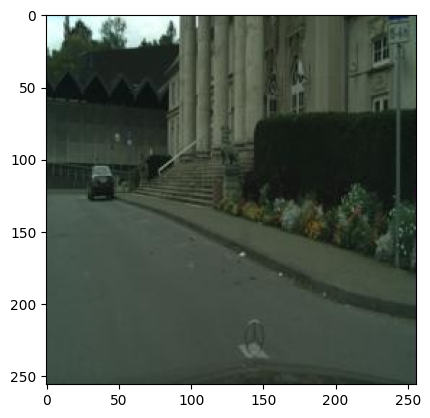

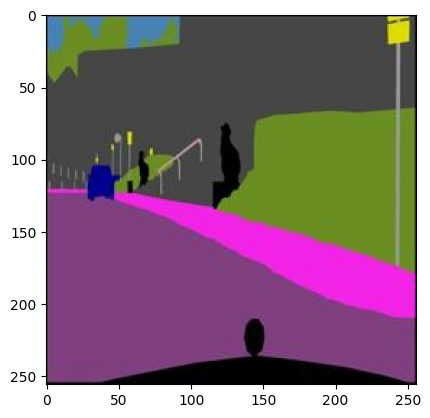

In [93]:
img1, img2 = preprocess(datapath+'train/8.jpg')

plt.figure()
plt.imshow(img1)
plt.figure()
plt.imshow(img2)



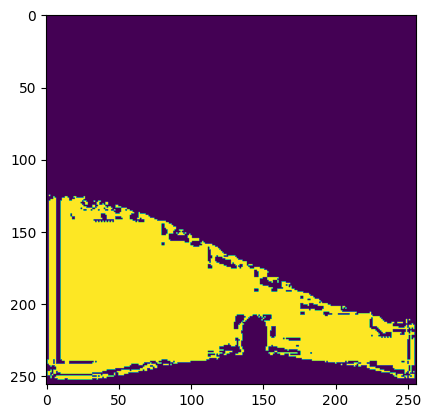

In [94]:
# Define the range of RGB values for roads
road_color_lower = np.array([110, 50, 120])
road_color_upper = np.array([130, 70, 130])

# Create road mask
road_mask = np.all((img2 >= road_color_lower) & (img2 <= road_color_upper), axis=-1)

# Convert boolean mask to an image with zeros and ones
road_mask = road_mask.astype(np.uint8) * 255

plt.imshow(road_mask)


In [ ]:
def prepare_tensor_dataset(train_path, val_path):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        img, mask = preprocess(f"{train_path}/{file}")
        X_train.append(img)
        Y_train.append(mask)

    for file in tqdm(os.listdir(val_path)):
        img, mask = preprocess(f"{val_path}/{file}")
        X_val.append(img)
        Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val